# MTG Card Data Analysis

## Objective

The objective of this notebook is to take a structured look at various elements of the corpus of Magic the Gathering cards created over the game's lifetime. I want to understand trends and generate data driven insights that help me understand how the game is changing and evolving over time.

### Index

* [Data and Script Preparation](#req_imports)
* [Load Data](#load_data)
* [Charts and Tables](#charts-and-tables)

## Data and Script Preparation
<a id="req_imports"></a>

### Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import zscore
import requests
from datetime import datetime, timedelta
import os
import glob
import json
import pprint


<div class="alert alert-block alert-info">
<b>NB:</b> Optionally you can edit the theme of the graphs using seaborn. Adjustments here will be made globally.</div>

In [2]:
sns.set_theme()
sns.set_context("poster")

### Load Data
<a id="load_data"></a>
There are two bulk data sets provided by scryfall

```
oracle-cards-***.json
default-cards-***.json
```

Both are valid datasets to analyze. I have chosen to analyze the default cards as it is the fuller of the two datasets containing every single card ever printed by WOTC rather than the `oracle-cards.json` that only contains one printing per card.

I have written a script that keeps the data file constantly up to date using the scryfall API. The script checks the current age of the file and if it is more than a week old it will pull a new one from the scryfall api and update the code to use the new one


In [3]:

# Constants for the API call
API_URL = "https://api.scryfall.com/bulk-data"

# Function to download the default cards file
def download_file(download_uri, filename):
    response = requests.get(download_uri)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded the new file: {filename}")
        return filename
    else:
        print("Failed to download file.")
        return None

# Step 1: Check the directory for the 'default-cards' file
file_pattern = "default-cards*.json"  # Adjust pattern as needed
file_list = glob.glob(file_pattern)
latest_file = None

# Determine the latest file based on the modification time
for file in file_list:
    if latest_file is None or os.path.getmtime(file) > os.path.getmtime(latest_file):
        latest_file = file

data_file = latest_file  # Assume the latest local file is the data file

# If there's no latest file found or it's older than a week, download a new one
if latest_file is None or (datetime.now() - datetime.fromtimestamp(os.path.getmtime(latest_file))) > timedelta(days=7):
    response = requests.get(API_URL)
    if response.status_code == 200:
        bulk_data_info = response.json()
        for entry in bulk_data_info.get("data", []):
            if entry["name"].lower() == "default cards":
                # Found the default cards entry, proceed to download
                filename = entry["download_uri"].split('/')[-1]
                data_file = download_file(entry["download_uri"], filename)
                break
    else:
        print("Failed to retrieve data from the API")
else:
    print(f"The latest data file available is '{data_file}' and it is not a week old yet.")

# Ensure `data_file` is not None and is the latest file
if data_file is None:
    print("No valid data file found or downloaded.")
else:
    print(f"Using the data file: {data_file}")

# At this point, `data_file` will have the name of the latest file

# Load data from the file
df= pd.read_json(data_file)

The latest data file available is 'default-cards-20231106100506.json' and it is not a week old yet.
Using the data file: default-cards-20231106100506.json


### Filter Data

It is important to filter this database so that i can control the data i am examining.

There are a wide number of sets on scryfall that i am not interested in.

I exclude any set with the below keywords in its name:

```
[
    "token", "playtest", "scheme", "planechase", "sticker", "art series", "alchemy", "anthology"
]
```

I also do not want to include unsets in my analysis so they are excluded.

2024 Data is temporarily excluded as, as of today, the full spoilers are not available and it is a distorting element on any predictive analytics.

In [4]:
# Keywords to exclude
excluded_keywords = ["token", "playtest", "scheme", "planechase", "sticker", "art series", "alchemy", "anthology"]

# Filter out sets based on keywords
df = df[~df['set_name'].str.lower().str.contains('|'.join(excluded_keywords))]

# Handle NaN values in 'oracle_text'
df['oracle_text'] = df['oracle_text'].fillna('')

# Remove sets with fewer than 30 cards
#filtered_sets = df['set_name'].value_counts()
#valid_sets = filtered_sets[filtered_sets >= 30].index
#df = df[df['set_name'].isin(valid_sets)]

# Filtering out rows where set_name starts with "un" (case-insensitive)
df = df[~df['set_name'].str.lower().str.startswith('un')]

# Assuming 'released_at' is a string representing dates, convert to datetime
df['released_at'] = pd.to_datetime(df['released_at'], errors='coerce')

# Drop rows with NaT in 'released_at' if any conversion errors occurred
df = df.dropna(subset=['released_at'])

# Extract year from 'released_at' datetime column
df['release_year'] = df['released_at'].dt.year

# Filter out all data from 2024
df = df[df['release_year'] != 2024]

## Data Analysis

<a id="charts_and_tables"></a> 

Finally the meat and potatoes of the whole endeavour.

#### Wordcloud

Just for fun generate a wordcloud of all of the words on magic cards since the first year

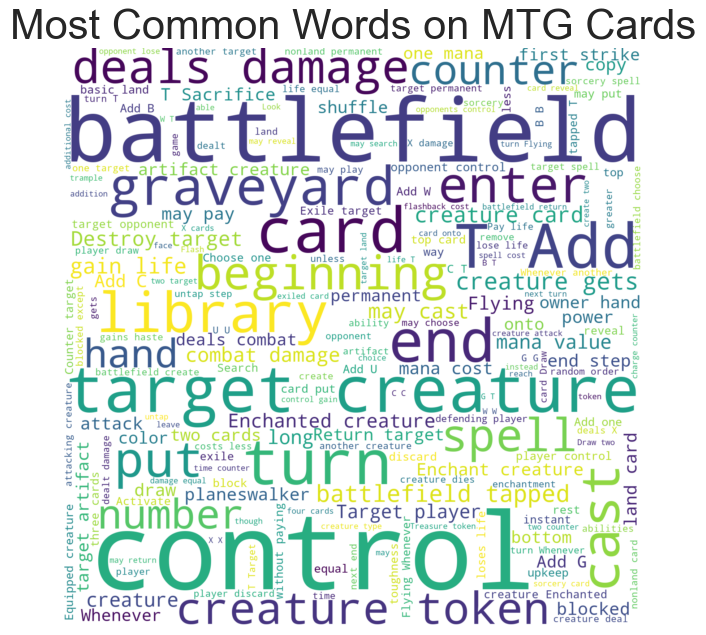

In [5]:
# Combine all oracle texts into one large string
all_text = ' '.join(df['oracle_text'].tolist())

# Generate a word cloud image
wordcloud = WordCloud(width=1600, height=1600, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Most Common Words on MTG Cards', fontsize=30)
plt.show()


### Some Bar Charts

Question - What is the average wordcount of sets released per year and how many NEW cards are released?

Method - Filter out any cards with the same name but a later release date to remove the reprints. Includes a trend lines

In this graph I can see that the average word count of new MTG cards has remained consistent throughout the years with a clearly defined upward trend. The number of unique new cards has exploded since 2018 to be consistently well in excess of 1500 new cards per year. This beats previous years by at least 200% in many cases

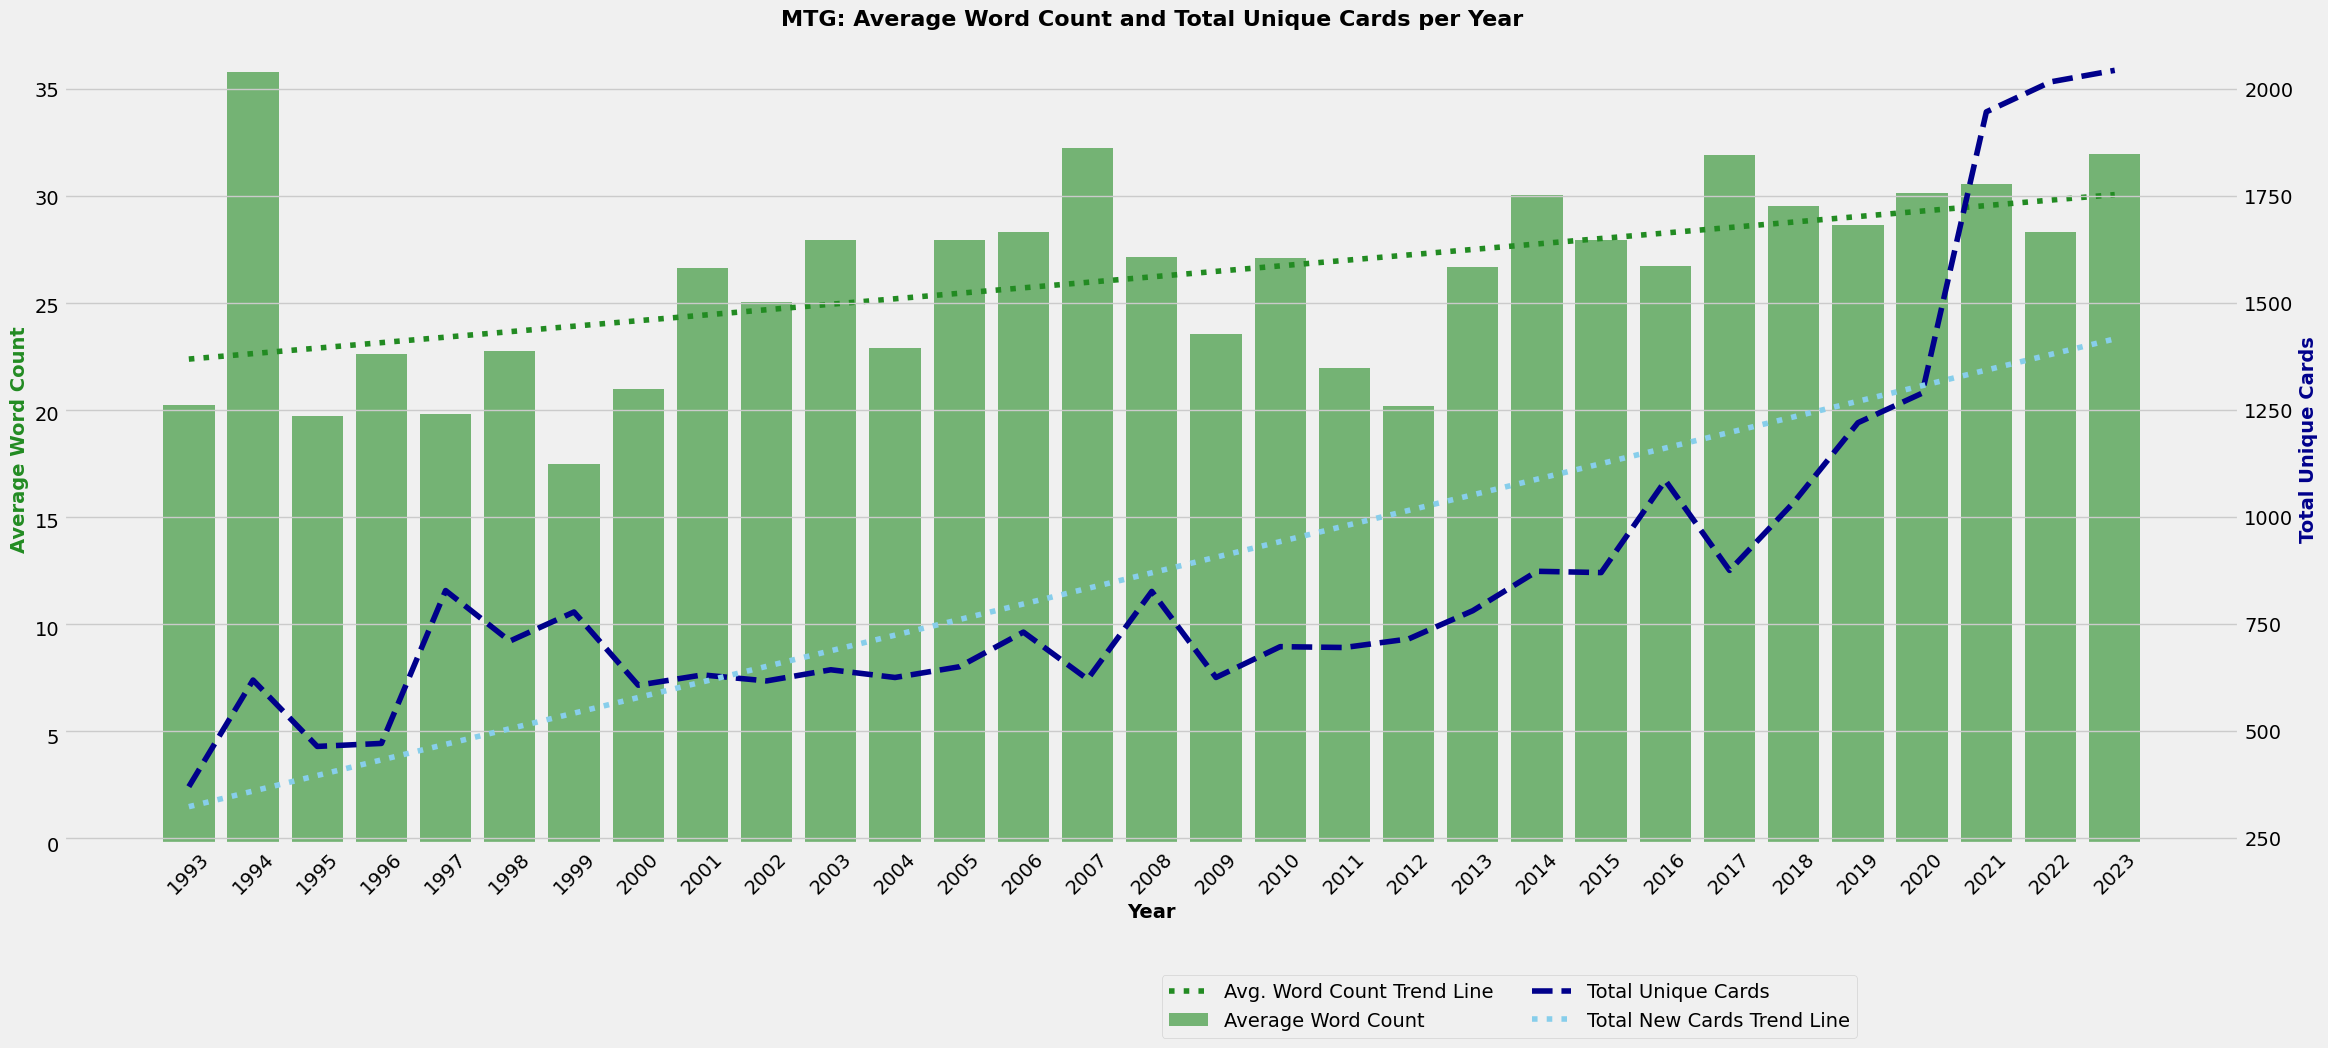

In [106]:
# Sort by 'name' and 'released_at' so that the earliest print of a card is first
df = df.sort_values(by=['name', 'released_at'])

# Drop duplicates keeping the first occurrence (which is the earliest release of a card)
df_unique = df.drop_duplicates(subset='name', keep='first').copy()

# Create a year column for grouping
df_unique['year'] = df_unique['released_at'].dt.year

# Calculate average word count per set per year
avg_word_count = df_unique.groupby(['set_name', 'year'])['oracle_text'].apply(lambda x: x.str.split().str.len().mean()).reset_index(name='average_word_count')

# Calculate total number of unique new cards released per year
total_unique_cards_yearly = df_unique.groupby('year')['name'].nunique().reset_index(name='total_unique_cards')

# Now for plotting
fig, ax1 = plt.subplots(figsize=(25, 10))

# First component: Average word count (bar graph)
avg_word_count_per_year = avg_word_count.groupby('year')['average_word_count'].mean()
ax1.bar(avg_word_count_per_year.index, avg_word_count_per_year.values, color='ForestGreen', alpha=0.6, label='Average Word Count')

# Second component: Total unique cards (line graph on secondary axis)
ax2 = ax1.twinx()
ax2.plot(total_unique_cards_yearly['year'], total_unique_cards_yearly['total_unique_cards'], color='darkblue', linestyle='--', label='Total Unique Cards')

# Calculate and plot the trend line for average word count
z = np.polyfit(avg_word_count_per_year.index, avg_word_count_per_year.values, 1)
p = np.poly1d(z)
ax1.plot(avg_word_count_per_year.index, p(avg_word_count_per_year.index), color='forestgreen',linestyle=':', label='Avg. Word Count Trend Line')

# Calculate and plot the trend line for total card count
z_total = np.polyfit(total_unique_cards_yearly['year'], total_unique_cards_yearly['total_unique_cards'], 1)
p_total = np.poly1d(z_total)
ax2.plot(total_unique_cards_yearly['year'], p_total(total_unique_cards_yearly['year']), color="skyblue", linestyle=':', label='Total New Cards Trend Line')

# Use a style sheet
style.use('fivethirtyeight')

# Adjust x-axis to show every year as an integer
ax1.set_xticks(avg_word_count_per_year.index)
ax1.set_xticklabels(avg_word_count_per_year.index.astype(int), rotation=45)

# Add a grid
ax1.grid(False)

# Change the font size and style
ax1.set_xlabel('Year', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Word Count', color='ForestGreen', fontsize=14, fontweight='bold')
ax2.set_ylabel('Total Unique Cards', color='darkblue', fontsize=14, fontweight='bold')
ax1.set_title('MTG: Average Word Count and Total Unique Cards per Year', fontsize=16, fontweight='bold')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Customizing legend placement to be under the x-axis
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.5, -0.15), ncol=2)

This leads me to think about what the future might hold. I have applied a regression to three subsets of the data to try to develop a forward looking set of trends.

The three trends are:

* Using all historic data (Circles)
* Using the last 5 years of historic data (Pentagon)
* Using the last 10 years of historic data (Diamond)

This information shows that the trends across the board are for an increasing rate of change. The shorter the time taken into account by the prediction the greater the predicted values are.

In particular the total number of unique cards released over the last five years pushes aggressively well above 3000 in the next ten years if we use the last five years as a baseline.

I would be wary of drawing long term conclusions from short timelines of data but it is indicative in viewing how much has changed in the near term.

<Figure size 640x480 with 0 Axes>

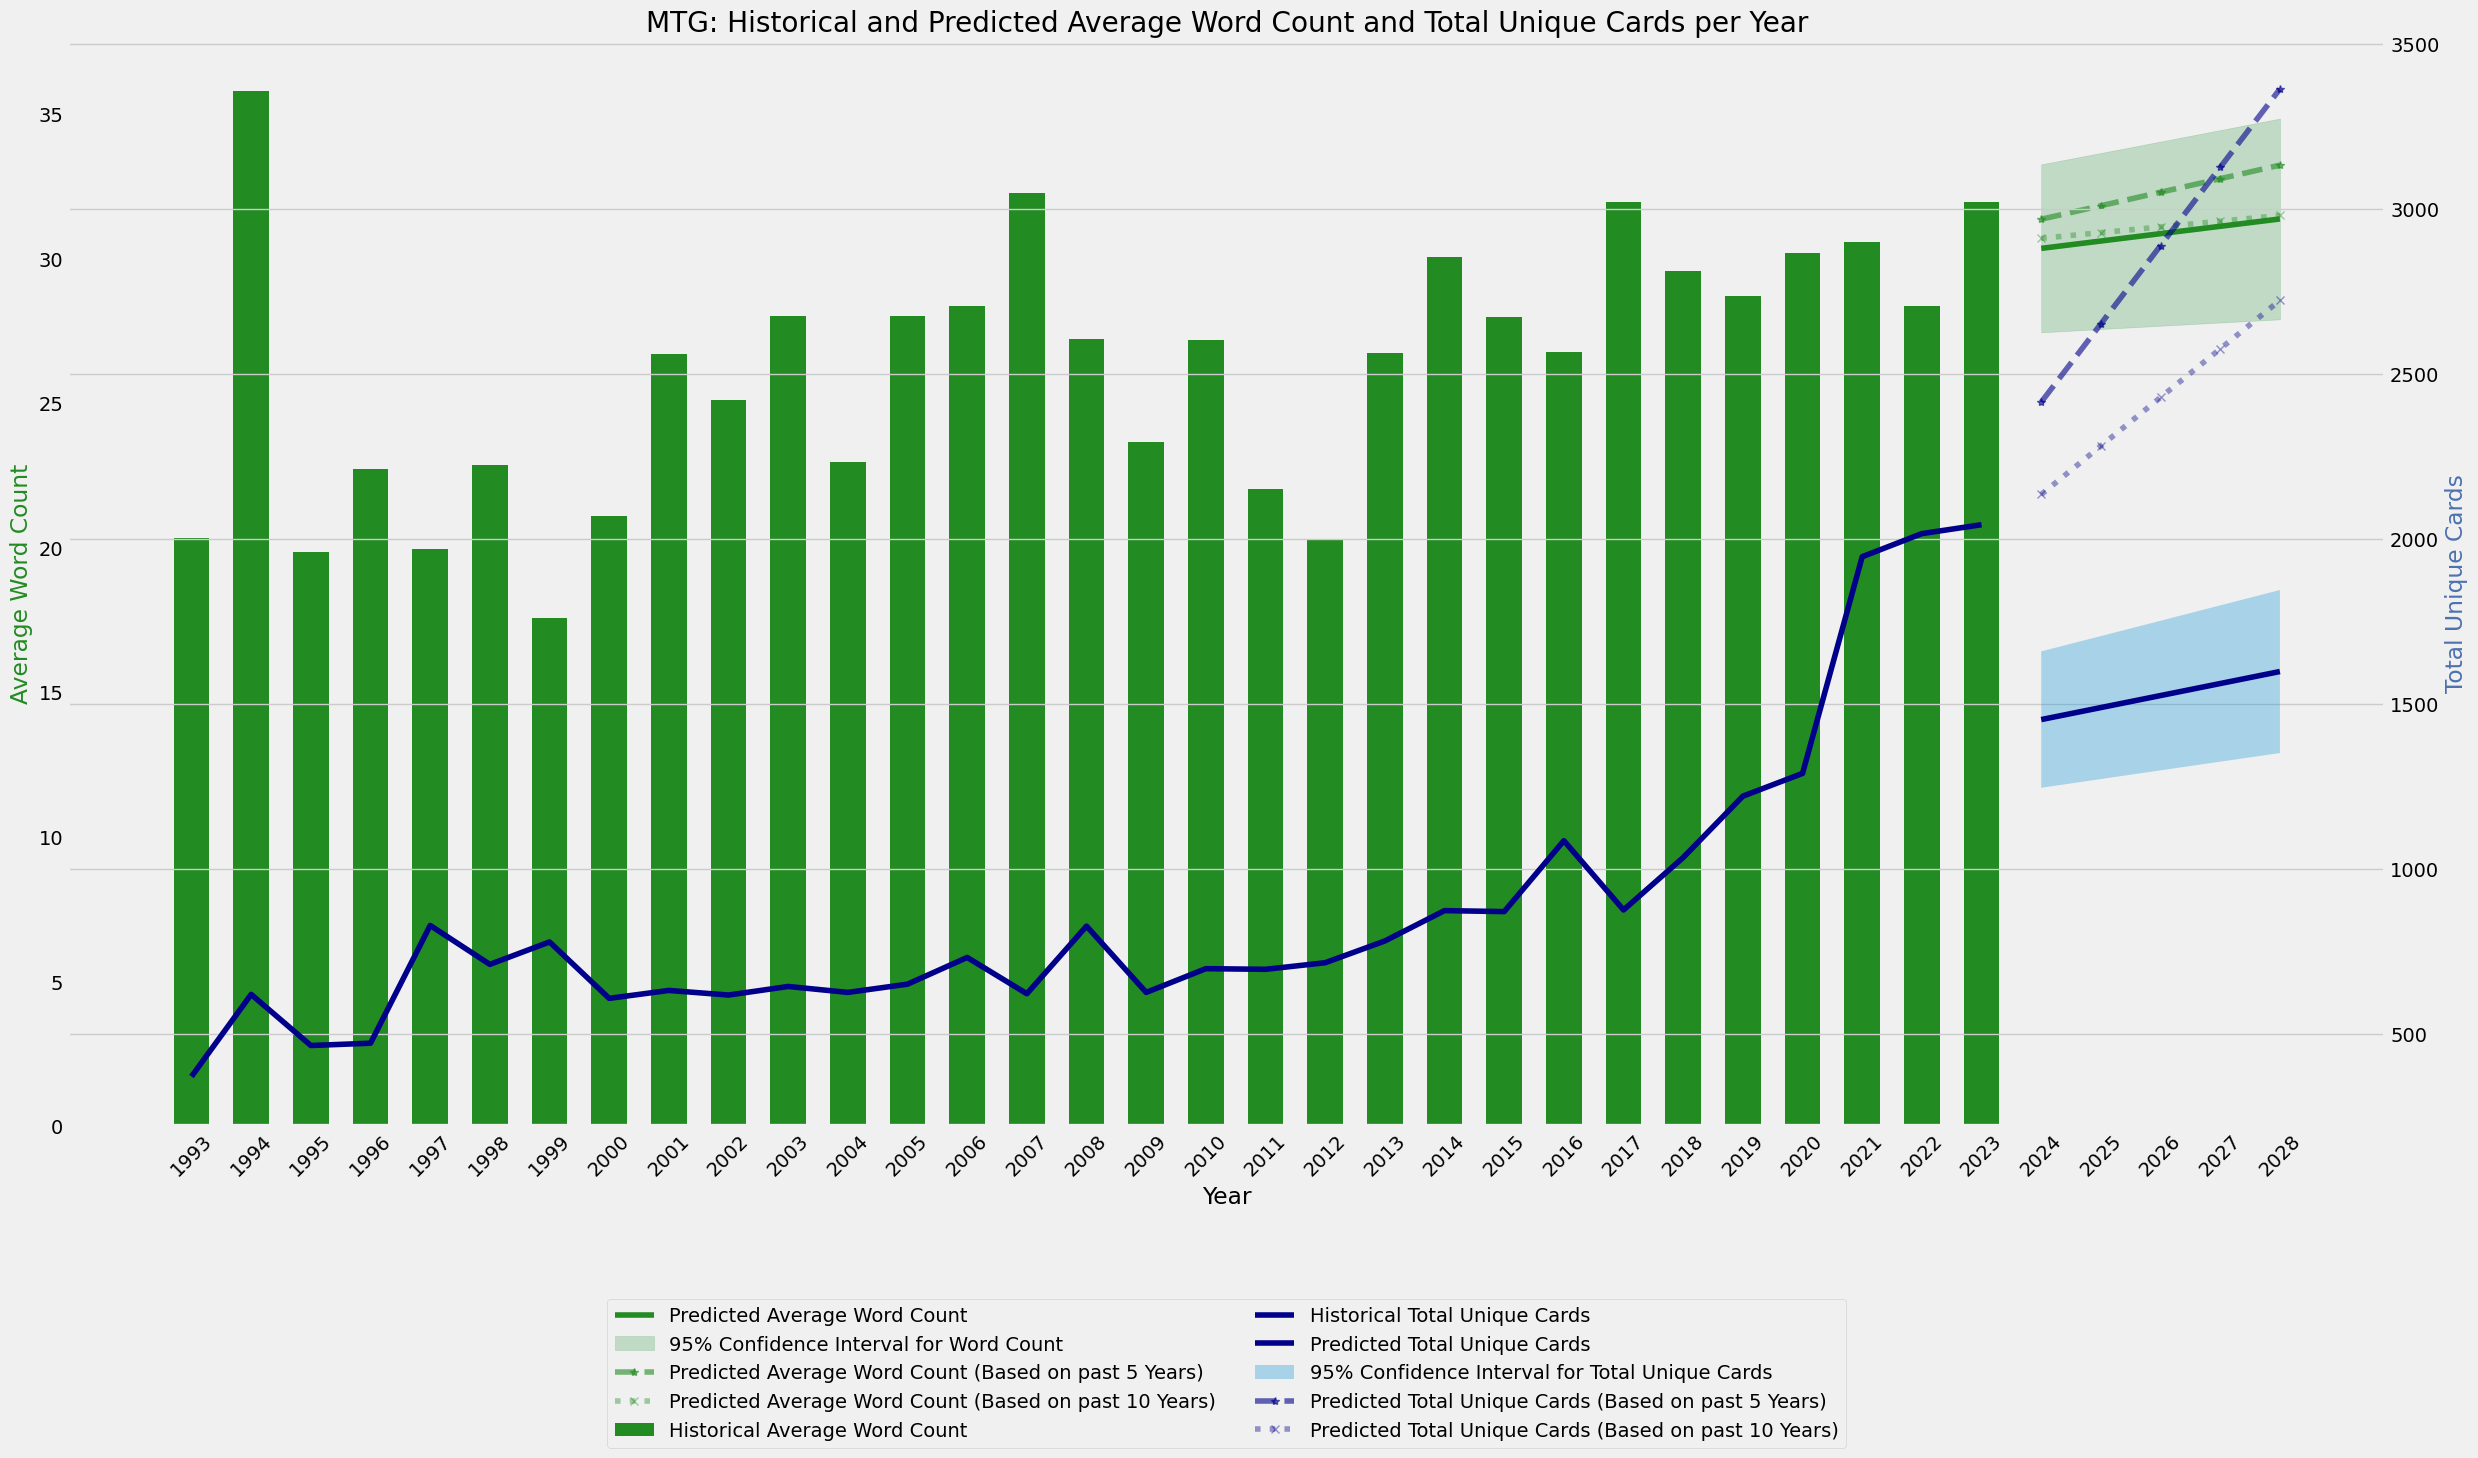

In [109]:
def predict_last_n_years(data, last_n_years, num_years_ahead):
    # Use the last N years for the model
    recent_data = data.tail(last_n_years)
    x_recent = sm.add_constant(recent_data.index)  # Add a constant term for the regression
    
    # Fit the model
    model = sm.OLS(recent_data.values, x_recent).fit()
    
    # Create future year indices for prediction
    predict_years = np.arange(recent_data.index[-1] + 1, recent_data.index[-1] + num_years_ahead + 1)
    x_future = sm.add_constant(predict_years)
    
    # Get predictions
    prediction = model.get_prediction(x_future)
    predicted_mean = prediction.predicted_mean
    predicted_intervals = prediction.conf_int(alpha=0.05)  # 95% confidence intervals
    
    return predict_years, predicted_mean, predicted_intervals, model

# Fit OLS regression models for each dataset
# Number of years to predict into the future
num_years_ahead = 5  


# For average word count data
x_wc = sm.add_constant(avg_word_count_per_year.index)  # x with constant for word count model
model_wc = sm.OLS(avg_word_count_per_year.values, x_wc).fit()

# For total unique cards data
x_uc = sm.add_constant(total_unique_cards_yearly['year'])  # x with constant for unique cards model
model_uc = sm.OLS(total_unique_cards_yearly['total_unique_cards'], x_uc).fit()

# Make predictions for the next ten years
predict_years_wc = np.arange(avg_word_count_per_year.index[-1] + 1, avg_word_count_per_year.index[-1] + num_years_ahead + 1)
predict_years_uc = np.arange(total_unique_cards_yearly['year'].iloc[-1] + 1, total_unique_cards_yearly['year'].iloc[-1] + num_years_ahead + 1)

# Prepare the prediction data frames with constants added
x_future_wc = sm.add_constant(predict_years_wc)
x_future_uc = sm.add_constant(predict_years_uc)

# Get predictions
prediction_wc = model_wc.get_prediction(x_future_wc)
predicted_mean_wc = prediction_wc.predicted_mean
predicted_intervals_wc = prediction_wc.conf_int(alpha=0.05)  # 95% confidence intervals for word count

prediction_uc = model_uc.get_prediction(x_future_uc)
predicted_mean_uc = prediction_uc.predicted_mean
predicted_intervals_uc = prediction_uc.conf_int(alpha=0.05)  # 95% confidence intervals for unique cards

# Predictions based on the last 5 and 10 years

# For average word count predictions
predict_years_5_wc, predicted_mean_5_wc, predicted_intervals_5_wc, model_5_wc = predict_last_n_years(
    avg_word_count_per_year, 5, num_years_ahead
)

predict_years_10_wc, predicted_mean_10_wc, predicted_intervals_10_wc, model_10_wc = predict_last_n_years(
    avg_word_count_per_year, 10, num_years_ahead
)

# For total unique cards predictions
predict_years_5_uc, predicted_mean_5_uc, predicted_intervals_5_uc, model_5_uc = predict_last_n_years(
    total_unique_cards_yearly.set_index('year')['total_unique_cards'], 5, num_years_ahead
)

predict_years_10_uc, predicted_mean_10_uc, predicted_intervals_10_uc, model_10_uc = predict_last_n_years(
    total_unique_cards_yearly.set_index('year')['total_unique_cards'], 10, num_years_ahead
)


# Plotting
plt.close('all')
plt.clf()
fig, ax1 = plt.subplots(figsize=(25, 15))
# Use a style sheet
style.use('fivethirtyeight')
# Define ax2 with a shared x-axis and independent y-axis
ax2 = ax1.twinx()
ax1.grid(False)

#Define Alphas
all_years_alpha = 1
five_years_alpha = 0.6
ten_years_alpha = 0.4


all_years_mark = "."
five_years_mark = "*"
ten_years_mark = "x"

all_years_line = '-'
five_years_line = '--'
ten_years_line = ':'

# Plot historical average word count data and add labels
bars = ax1.bar(avg_word_count_per_year.index, avg_word_count_per_year.values, color='ForestGreen', alpha=1, width=0.6, label='Historical Average Word Count')

# Plot future predictions for average word count with confidence intervals and add labels
ax1.plot(predict_years_wc, predicted_mean_wc, color='forestgreen', label='Predicted Average Word Count', alpha=all_years_alpha)
ax1.fill_between(predict_years_wc, predicted_intervals_wc[:, 0], predicted_intervals_wc[:, 1],color='g',alpha=0.3, label='95% Confidence Interval for Word Count')

#Plot future predictions for average word count 5 years ahead with confidence intervals and add labels
ax1.plot(predict_years_5_wc, predicted_mean_5_wc, label='Predicted Average Word Count (Based on past 5 Years)',color='forestgreen',linestyle=five_years_line,marker=five_years_mark, alpha=five_years_alpha)
#ax1.fill_between(predict_years_5_wc, predicted_intervals_5_wc[:, 0], predicted_intervals_5_wc[:, 1], color='g', alpha=0.1, label='95% Confidence Interval for Word Count (5 Years)')

#Plot future predictions for average word count 10 years ahead with confidence intervals and add labels
ax1.plot(predict_years_10_wc, predicted_mean_10_wc,color='forestgreen',linestyle=ten_years_line,marker=ten_years_mark, label='Predicted Average Word Count (Based on past 10 Years)', alpha=ten_years_alpha)
#ax1.fill_between(predict_years_10_wc, predicted_intervals_10_wc[:, 0], predicted_intervals_10_wc[:, 1], color='g', alpha=0.05, label='95% Confidence Interval for Word Count (10 Years)')

# Plot historical total unique cards data and add labels
ax2.plot(total_unique_cards_yearly['year'], total_unique_cards_yearly['total_unique_cards'], color='darkblue', label='Historical Total Unique Cards')

# Plotting future predictions for total unique cards
ax2.plot(predict_years_uc, predicted_mean_uc, color='darkblue', label='Predicted Total Unique Cards', zorder=5, alpha=all_years_alpha)
ax2.fill_between(predict_years_uc, predicted_intervals_uc[:, 0], predicted_intervals_uc[:, 1], alpha=0.3, label='95% Confidence Interval for Total Unique Cards')

# Plot future predictions for total unique cards 5 years ahead with confidence intervals and add labels
ax2.plot(predict_years_5_uc, predicted_mean_5_uc, label='Predicted Total Unique Cards (Based on past 5 Years)', color='darkblue',linestyle=five_years_line,marker=five_years_mark,  alpha=five_years_alpha)
#ax2.fill_between(predict_years_5_uc, predicted_intervals_5_uc[:, 0], predicted_intervals_5_uc[:, 1], color='b', alpha=0.1, label='95% Confidence Interval for Total Unique Cards (5 Years)')

# Plot future predictions for total unique cards 10 years ahead with confidence intervals and add labels
ax2.plot(predict_years_10_uc, predicted_mean_10_uc, label='Predicted Total Unique Cards (Based on past 10 Years)', color='darkblue',linestyle=ten_years_line,marker=ten_years_mark, alpha=ten_years_alpha)
#ax2.fill_between(predict_years_10_uc, predicted_intervals_10_uc[:, 0], predicted_intervals_10_uc[:, 1], color='b', alpha=0.05, label='95% Confidence Interval for Total Unique Cards (10 Years)')


# Set the labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count', color='forestgreen')
ax2.set_ylabel('Total Unique Cards', color='b')
ax1.set_title('MTG: Historical and Predicted Average Word Count and Total Unique Cards per Year')

# Adjust ticks and labels on x-axis to include all years
all_years = np.concatenate((avg_word_count_per_year.index, predict_years_wc))
ax1.set_xticks(all_years)
ax1.set_xticklabels([str(year) for year in all_years], rotation=45)

# Combine legends from both axes into one
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Customizing legend placement to be under the x-axis
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

# Close the plot explicitly to avoid resource warnings
plt.close(fig)

It is no secret that the number of releases is increasing. The next graph attempts to demonstrate that

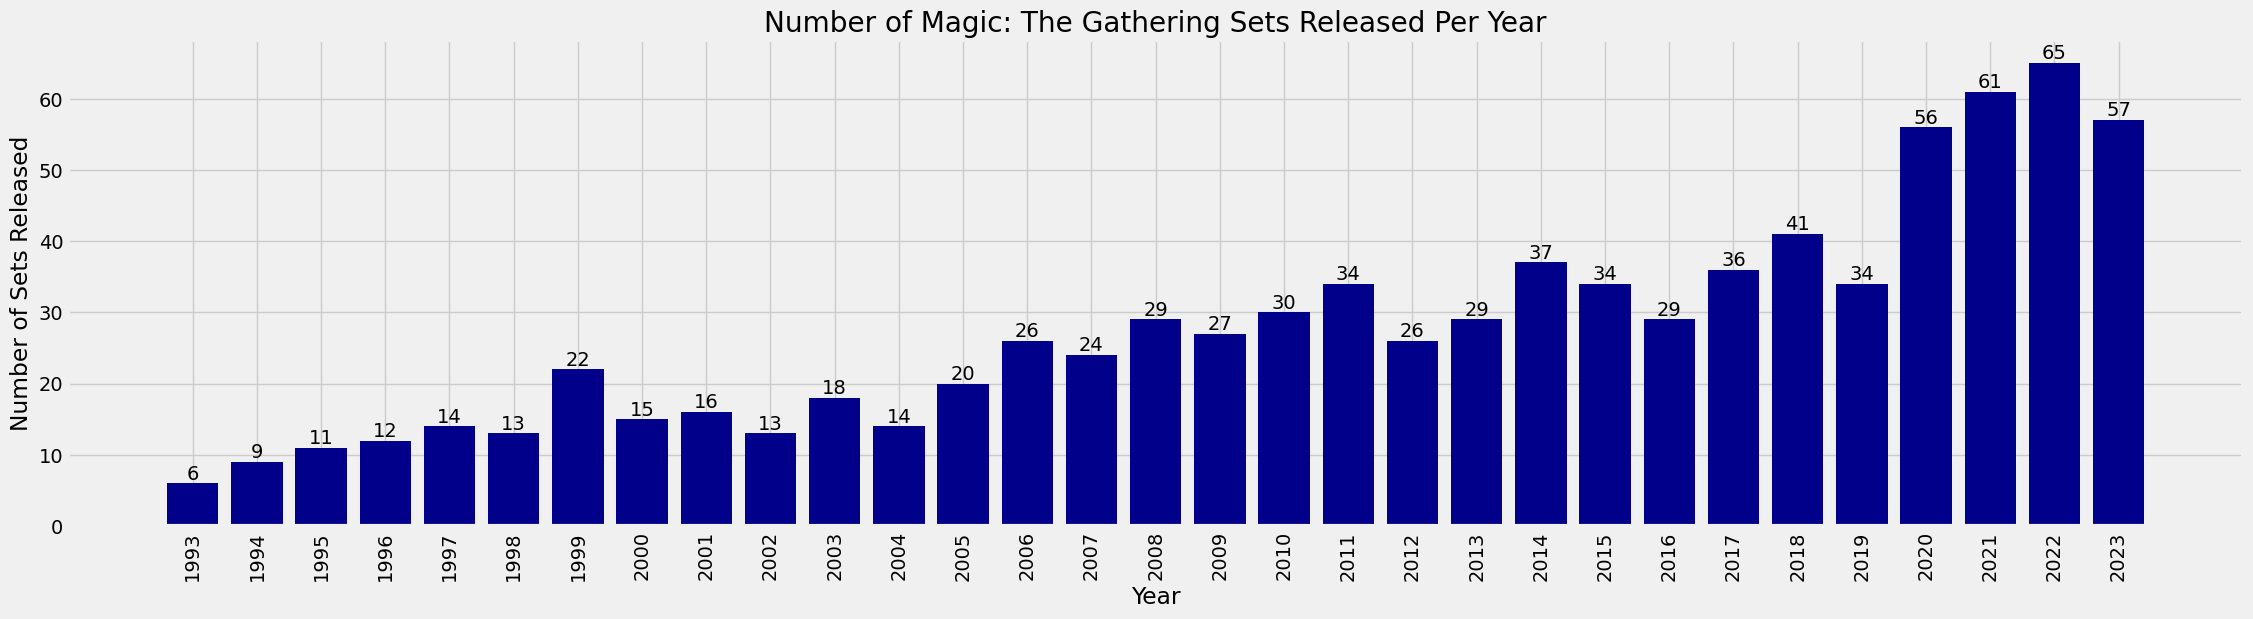

In [108]:
df['year'] = df['released_at'].dt.year  # Extract year from 'released_at'

# Count unique sets per year
sets_per_year = df.groupby('year')['set_name'].nunique().reset_index()

# Rename columns for clarity
sets_per_year.columns = ['Year', 'Number of Sets Released']

# Create a bar chart
plt.figure(figsize=(25,6))  # Set the figure size as desired
plt.bar(sets_per_year['Year'], sets_per_year['Number of Sets Released'], color='darkblue')  # Choose your color

# Add some labels and a title
plt.xlabel('Year')
plt.ylabel('Number of Sets Released')
plt.title('Number of Magic: The Gathering Sets Released Per Year')

# Set x-axis ticks to show every year label
plt.xticks(sets_per_year['Year'], rotation=90)  # Rotate labels to avoid overlap if necessary


# Optionally, add text labels above the bars
for i, val in enumerate(sets_per_year['Number of Sets Released']):
    plt.text(sets_per_year['Year'][i], val, str(val), ha='center', va='bottom')

# Show the plot
plt.show()


---

## Focus on Commander

Let's look at Commander Data

First filter to only commander sets to see how that has changed.
Fully look at commanders
Blend EDHREC Data?

Filters

1. Set name contains the word "Commander"
2. Set name does not contain "minigame"
3. Type line does not contain "token"

Dataframes

1. commander_df - Filtered dataframe
2. unique_commander_df - Filtered dataframe with unique cards. Only the earliest printing is kept. This should show reprints

We want to look at commander cards as part of the wider corpus of MTG cards

To facilitate this we take the earliest printing of each card and apply filters to get out graphs

Total legendary cards: 3303


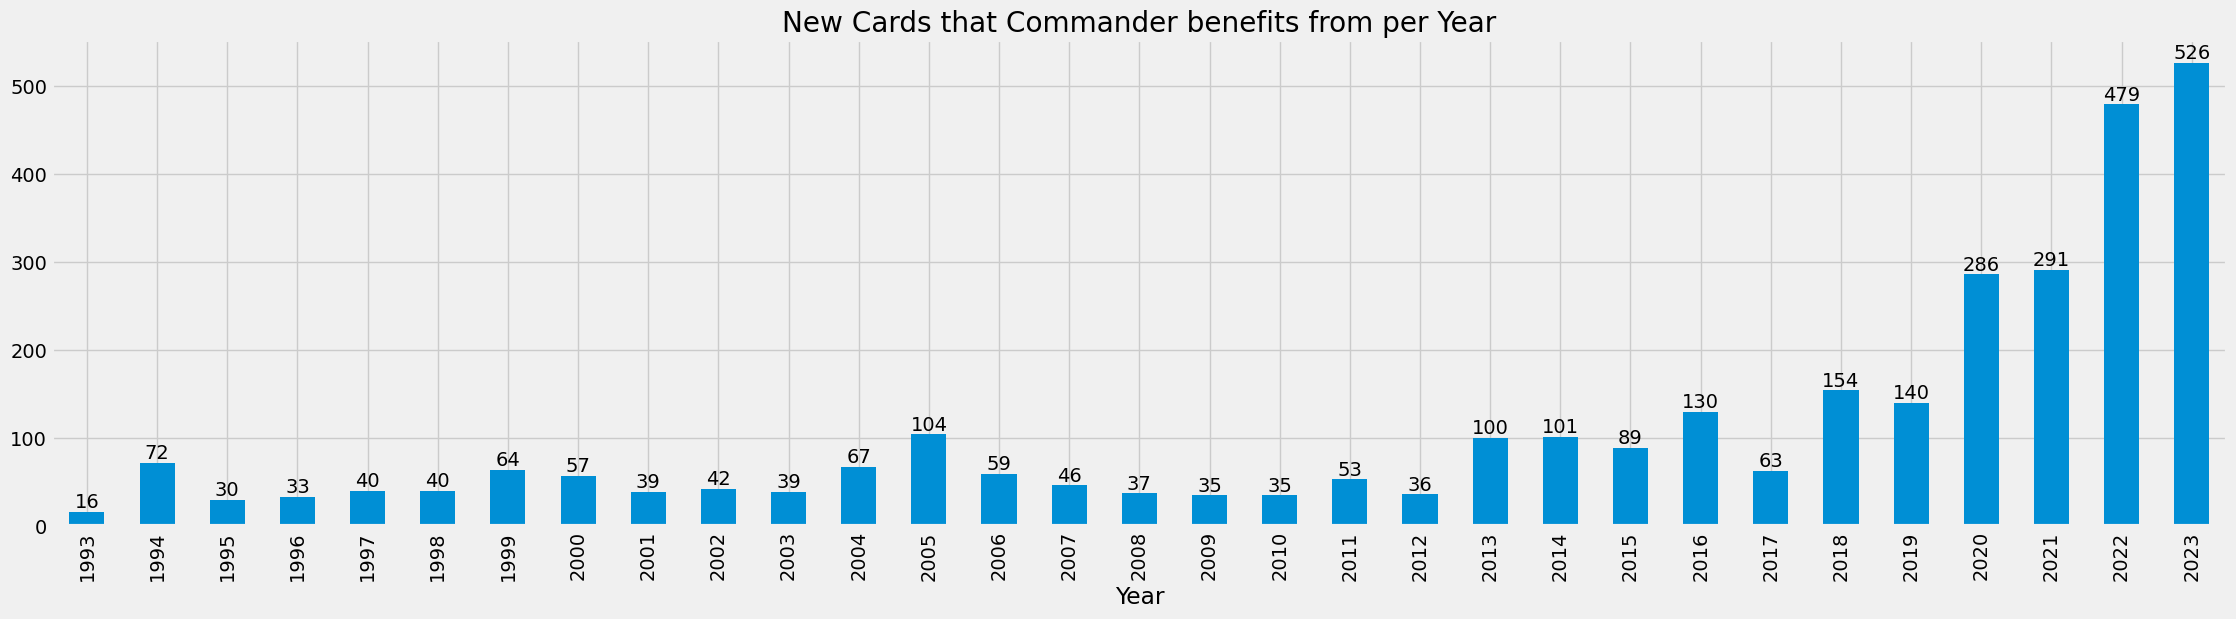

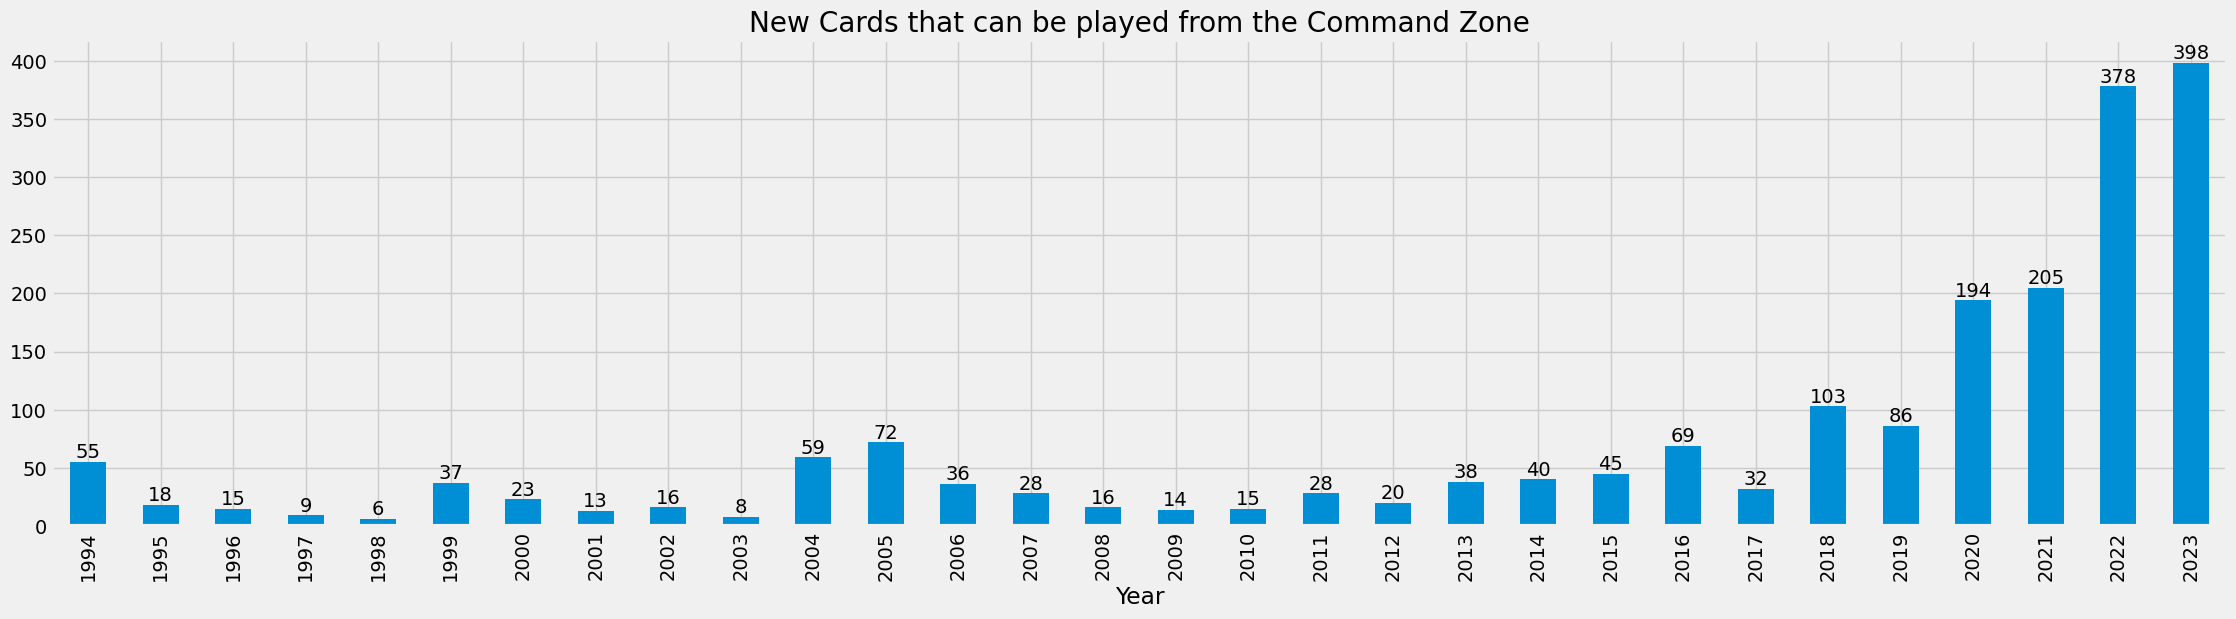

In [107]:
#Sort the values in descnding order then drop duplicates keeping the first one. This will keep only the oldest version of each card
df = df.sort_values(by='released_at', ascending=True)
unique_df = df.drop_duplicates(subset='name', keep='first')

# Filters for commander cards
commander_cards = df['oracle_text'].str.contains('each opponent', case=False, na=False) | df['oracle_text'].str.contains('each player', case=False, na=False)
legendary_creatures = df['type_line'].str.contains('legendary', case=False, na=False) & df['type_line'].str.contains('creature', case=False, na=False)
backgrounds = df['type_line'].str.contains('background', case=False, na=False)
planes_walker_cmdrs = df['oracle_text'].str.contains('can be your commander', case=False, na=False)

#Combine the filters into one
commander_players_stuff_filter = backgrounds | legendary_creatures | planes_walker_cmdrs | commander_cards

# Ensure that the boolean series has the same index as the DataFrame
commander_players_stuff_filter = commander_players_stuff_filter.reindex(unique_df.index)

# Use the filter to create a new DataFrame
commander_cards_df = unique_df.loc[commander_players_stuff_filter]

# Create a copy of the DataFrame
commander_cards_df = commander_cards_df.copy()

# Extract the Year from the 'released_at' datetime column
commander_cards_df.loc[:, 'year'] = pd.to_datetime(commander_cards_df['released_at']).dt.year


# Group the data by 'year' and get the number of cards in each group
commander_cards_per_year = commander_cards_df.groupby('year').size()

# Create a graph showing the number of cards per year
ax = commander_cards_per_year.plot(kind='bar', figsize=(25, 6))

plt.title('New Cards that Commander benefits from per Year')
plt.xlabel('Year')
#plt.ylabel('Number of Cards') # Don't need this label as it is in the title

# Add data labels to the bars
for i, v in enumerate(commander_cards_per_year):
    ax.text(i, v, str(v), ha='center', va='bottom')
print(f"Total legendary cards: {len(commander_cards_df)}")

plt.show()

#Look at legendary creatures only by creating a filter
valid_commander_filter = legendary_creatures | planes_walker_cmdrs | backgrounds
valid_commander_filter = valid_commander_filter.reindex(unique_df.index)

#create a new DataFrame with the filter
legendary_creatures_df = unique_df.loc[valid_commander_filter]

# Create a copy of the DataFrame
legendary_creatures_df = legendary_creatures_df.copy()

# Extract the year from the 'released_at' datetime column
legendary_creatures_df.loc[:, 'year'] = pd.to_datetime(legendary_creatures_df['released_at']).dt.year

#Group by year and get the number of cards in each group
legendary_creatures_per_year = legendary_creatures_df.groupby('year').size()

# Create a graph showing the number of cards per year
ax = legendary_creatures_per_year.plot(kind='bar', figsize=(25, 6))

plt.title('New Cards that can be played from the Command Zone')
plt.xlabel('Year')
#plt.ylabel('Number of Cards') # Don't need this label as it is in the title

# Add data labels to the bars
for i, v in enumerate(legendary_creatures_per_year):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.show()

---
### Only Commander Sets

It has been rightly pointed out that this data might be meaningless. It is what it is. I did the work so I am leaving it here in case I think of a use for it.

In [10]:
commander_df = df[df['set_name'].str.contains('commander', case=False, na=False)]
commander_df = commander_df[~commander_df['set_name'].str.contains("minigame", case=False, na=False)]
# Filter rows where 'type_line' contains "token"
commander_df = commander_df[~commander_df['type_line'].str.contains('token', case=False, na=False)]

unique_sets = commander_df['set_name'].unique()

print(f"Unique sets: {len(unique_sets)}")
print(f"Total cards: {len(commander_df)}")
print(f"Total unique cards: {len(commander_df['name'].unique())}")
print(f"Total unique cards with oracle text: {len(commander_df[commander_df['oracle_text'] != '']['name'].unique())}")
print()

# for set_name in unique_sets:
#     print(set_name)

# Sort the DataFrame by 'released_at' in ascending order
unique_commander_df = commander_df.sort_values(by='released_at')

# Drop duplicates based on the 'name' column and keep only the earliest version of each unique name
unique_commander_df = commander_df.drop_duplicates(subset='name', keep='first')

print(f"Total unique cards check: {len(unique_commander_df) == len(commander_df['name'].unique())}")
# Compare the number of unique cards and print the result as a boolean

Unique sets: 48
Total cards: 11013
Total unique cards: 5036
Total unique cards with oracle text: 4973

Total unique cards check: True


Graphs of all cards

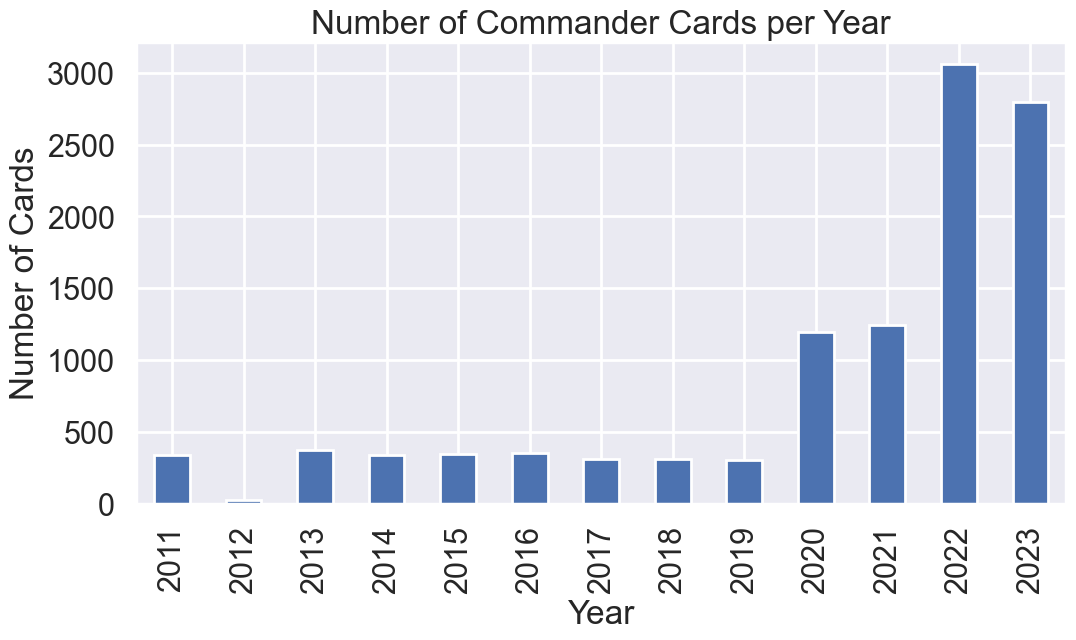

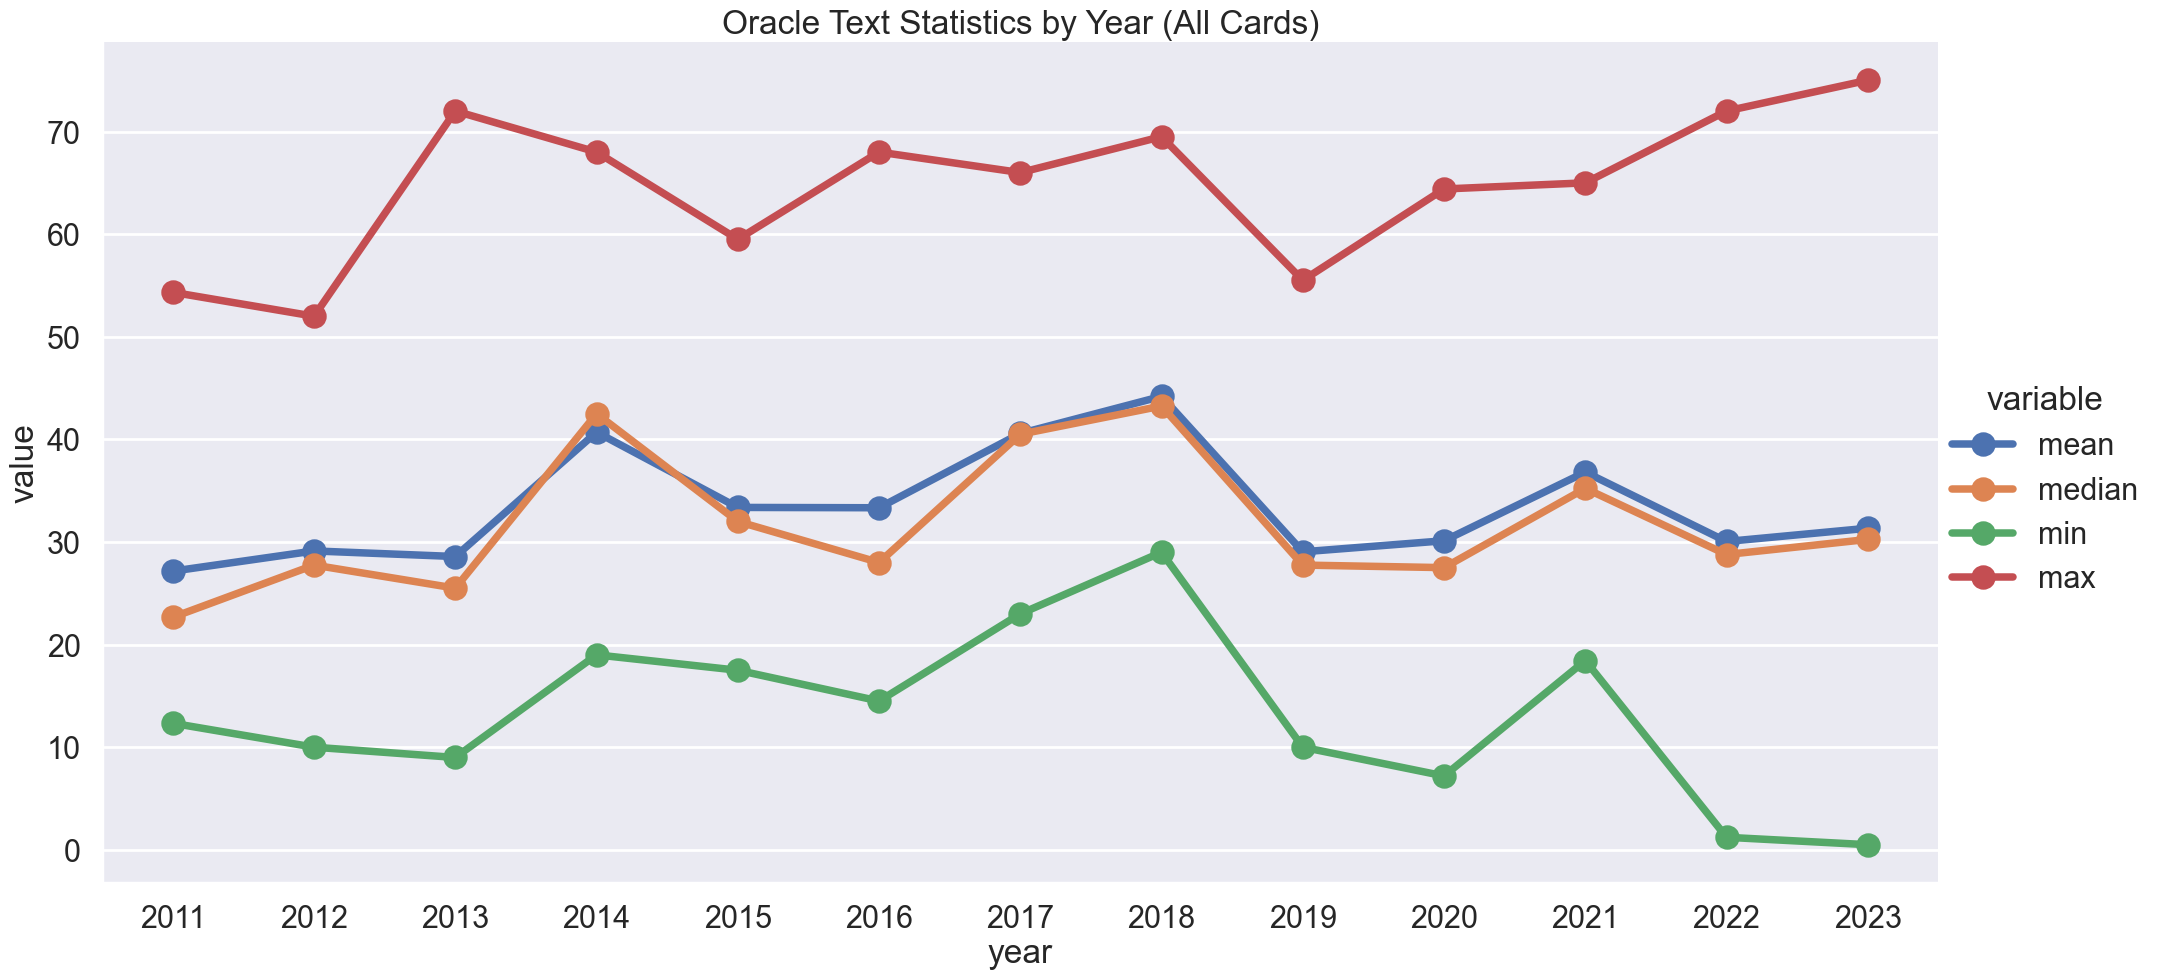

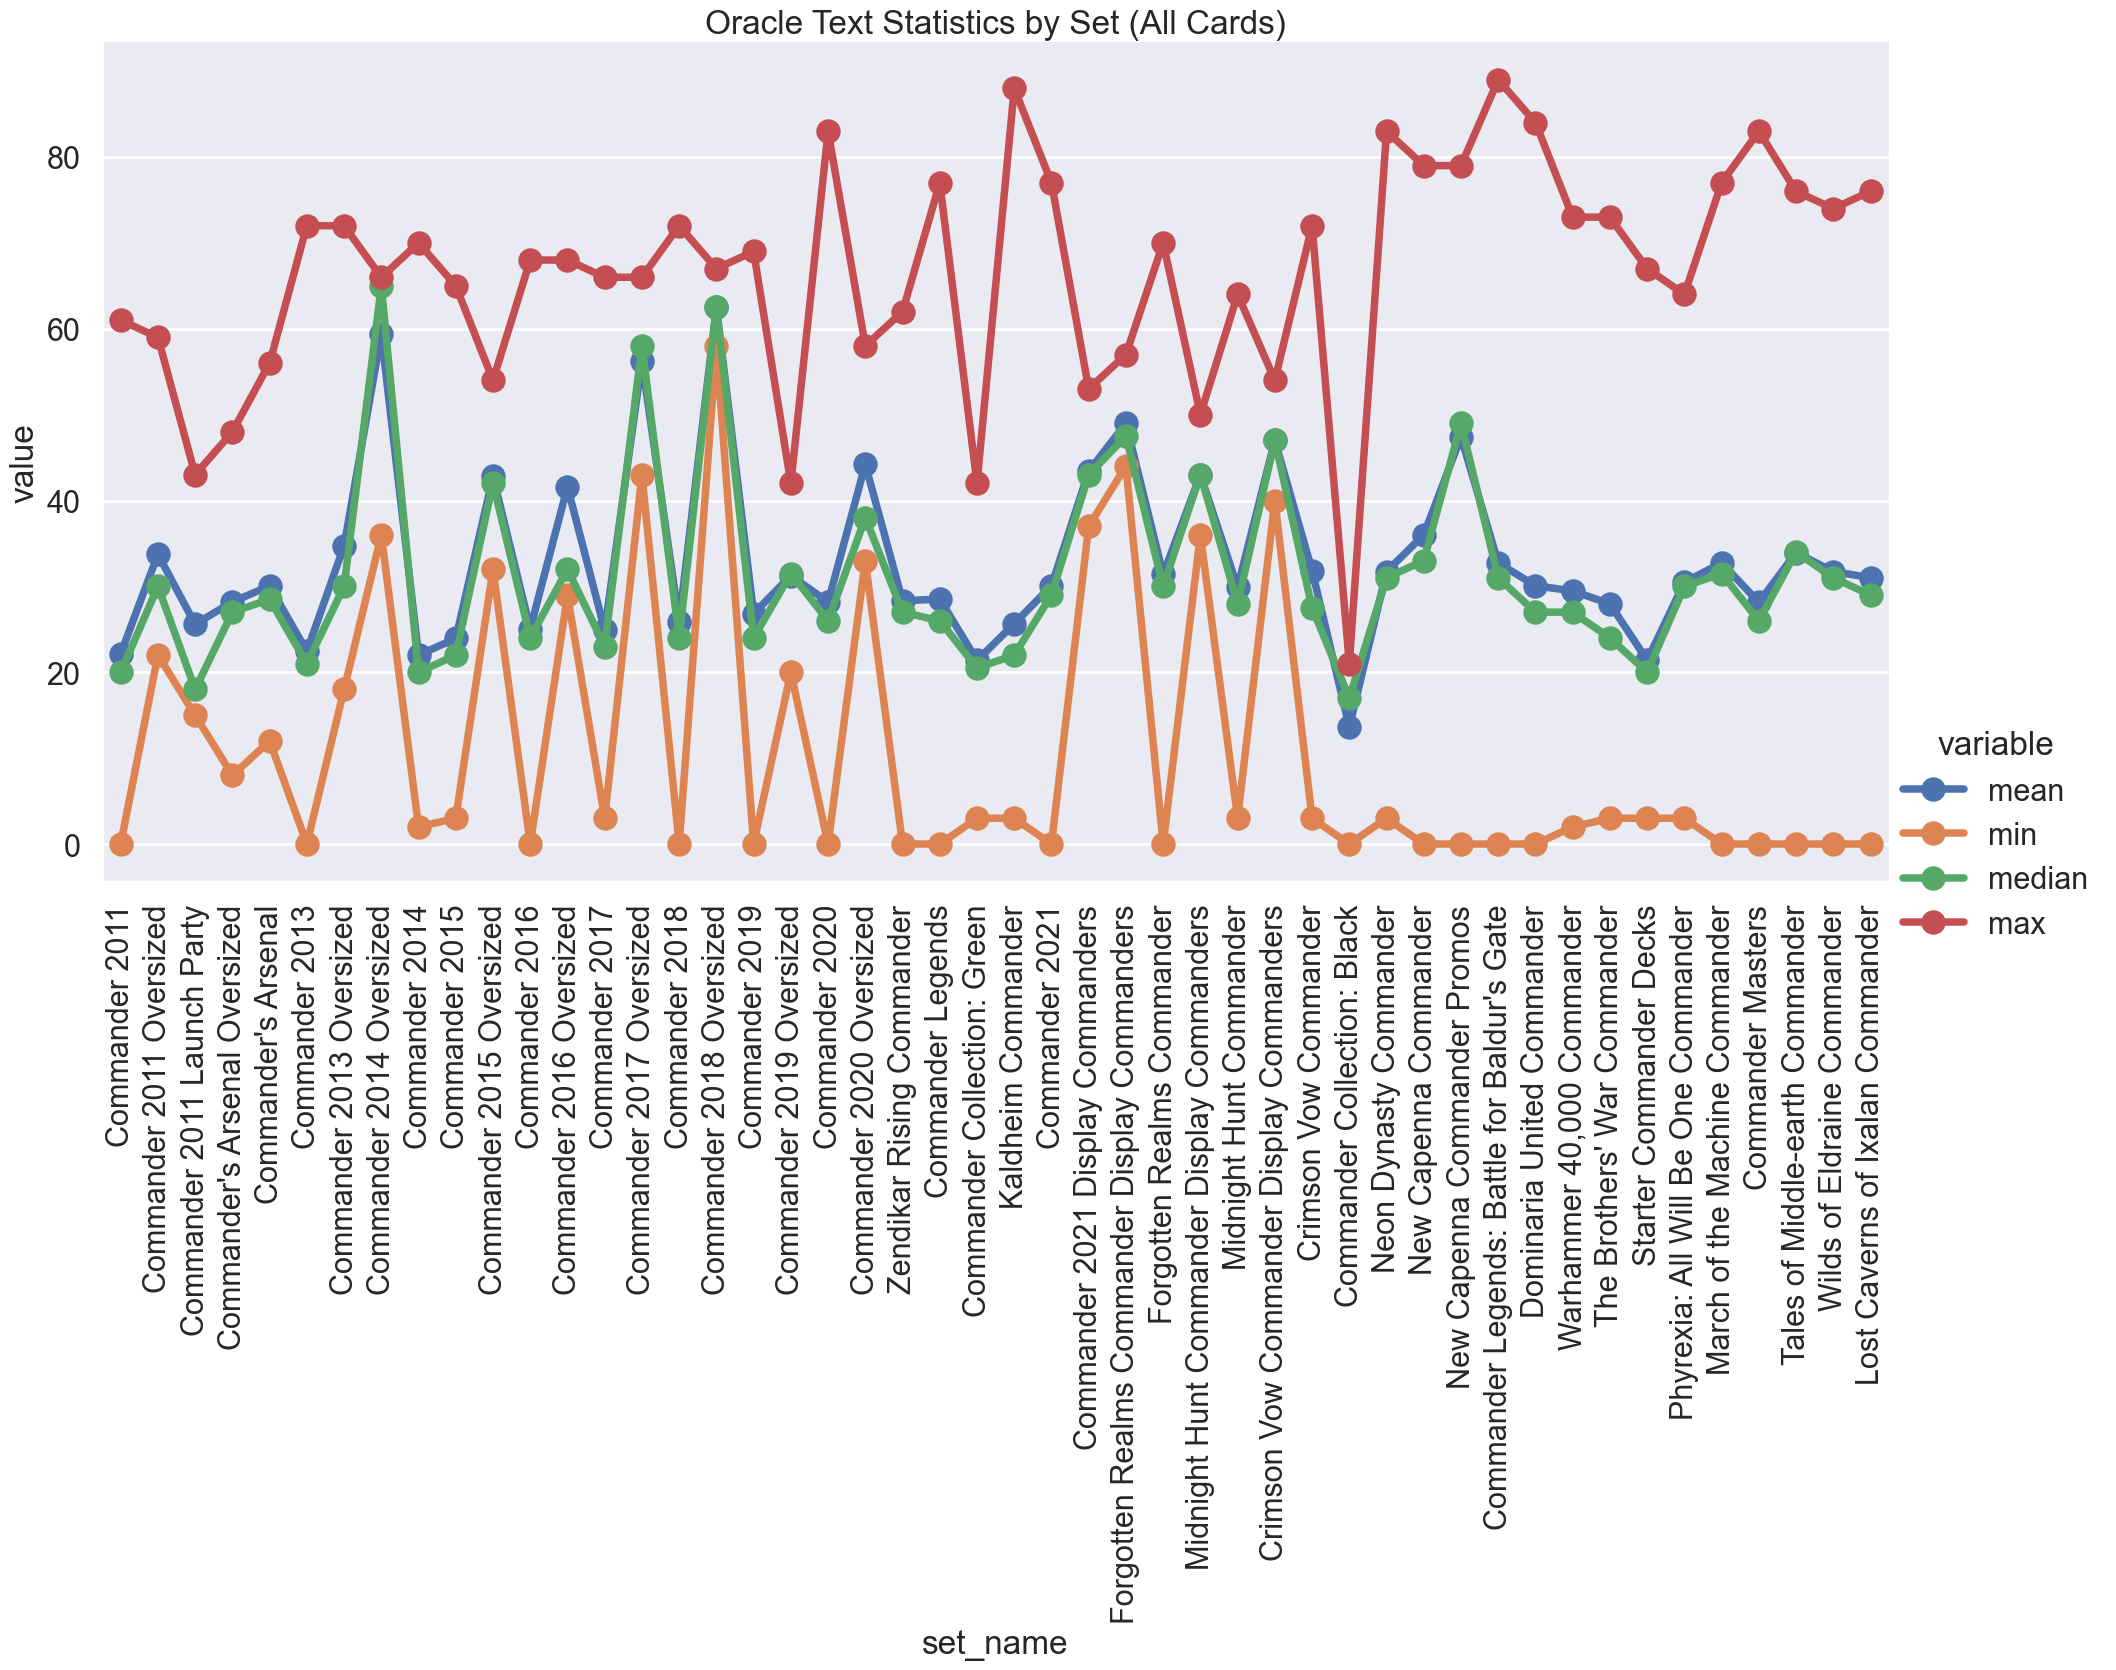

In [11]:
commander_df.loc[:, 'released_at'] = pd.to_datetime(commander_df['released_at'])
commander_df.loc[:, 'year'] = commander_df['released_at'].dt.year

# Group the data by 'year' and get the number of cards in each group
cards_per_year = commander_df.groupby('year').size()

# Create a graph showing the number of cards per year
cards_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Commander Cards per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')
plt.show()

# Count the number of words in each oracle_text
commander_df.loc[:, 'word_count'] = commander_df['oracle_text'].apply(lambda x: len(str(x).split()))

# Group by set and year, and calculate mean, median, min, and max word count
stats = commander_df.groupby(['set_name', 'year'])['word_count'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Reshape the DataFrame for easier plotting
melted_stats = stats.melt(id_vars=['set_name', 'year'], value_vars=['mean', 'median', 'min', 'max'])

# Create a bar plot with 'year' on the x-axis
sns.catplot(data=melted_stats, x='year', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.title('Oracle Text Statistics by Year (All Cards)')
plt.show()

# Merge 'released_at' back into the 'melted_stats' DataFrame
melted_stats = pd.merge(melted_stats, commander_df[['set_name', 'year', 'released_at']].drop_duplicates(), on=['set_name', 'year'], how='left')

# Sort the DataFrame by 'released_at'
melted_stats_sorted = melted_stats.sort_values(by='released_at')

# Create a bar plot with 'set_name' on the x-axis
sns.catplot(data=melted_stats_sorted, x='set_name', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Oracle Text Statistics by Set (All Cards)')
plt.show()

Now with the reprints removed

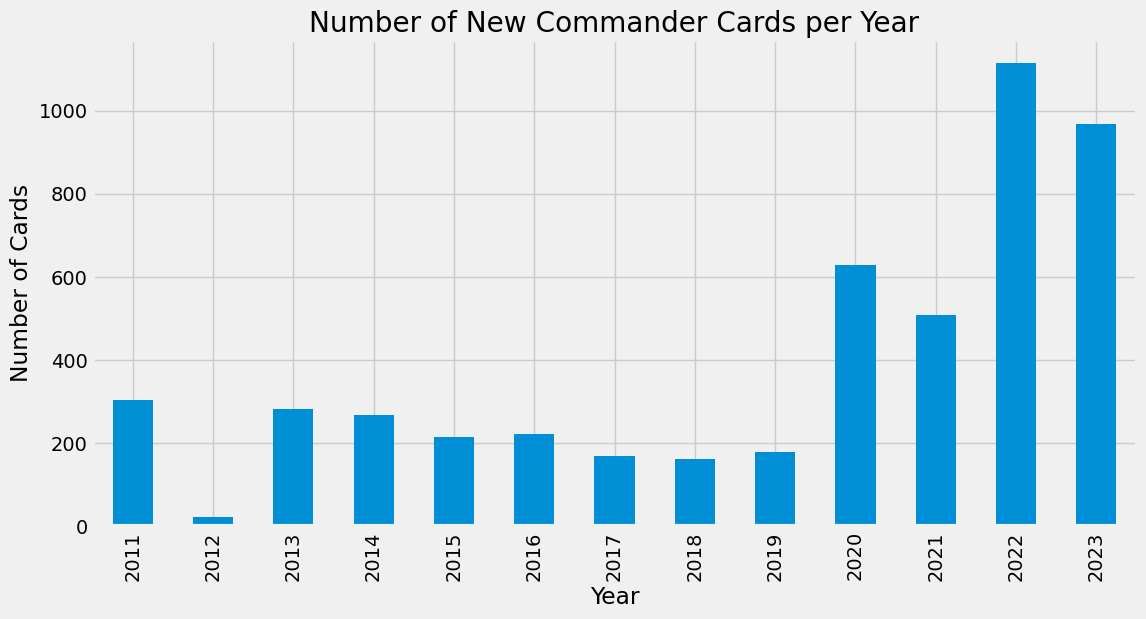

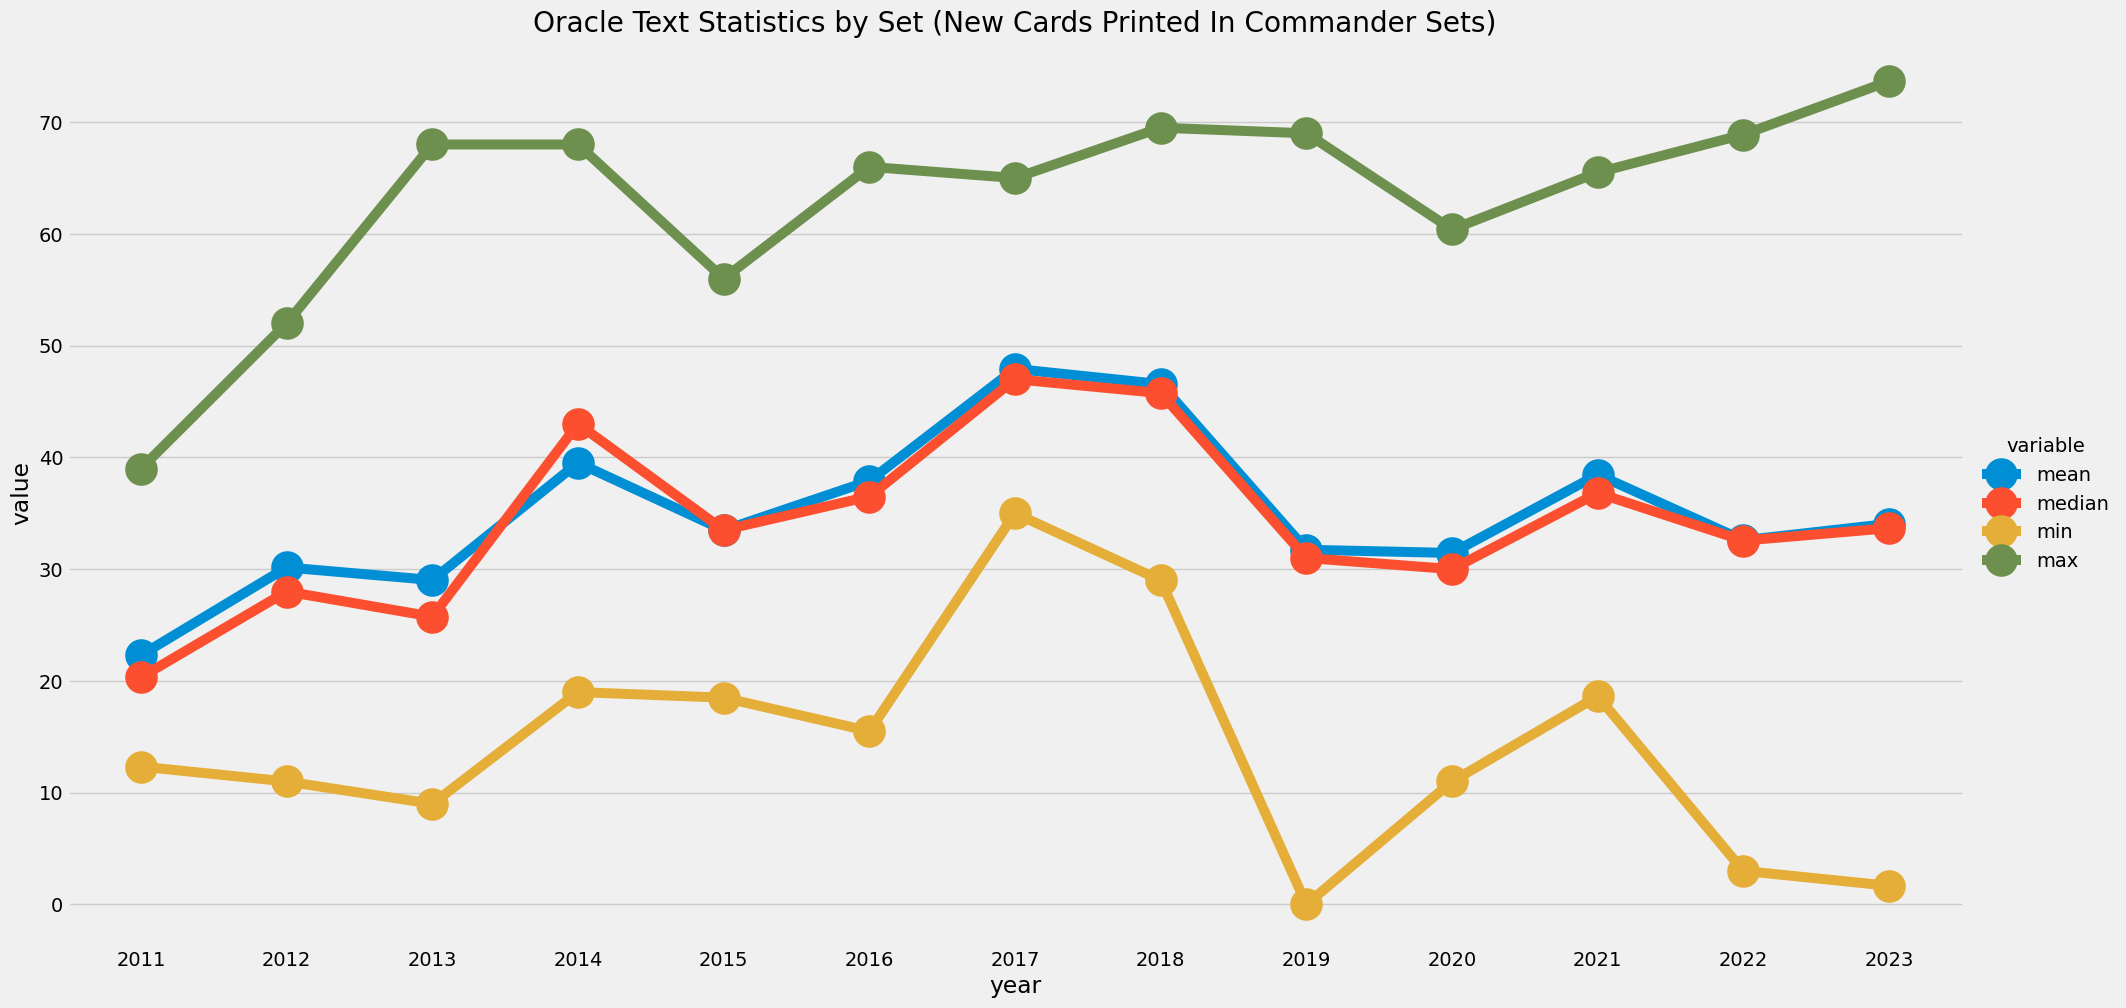

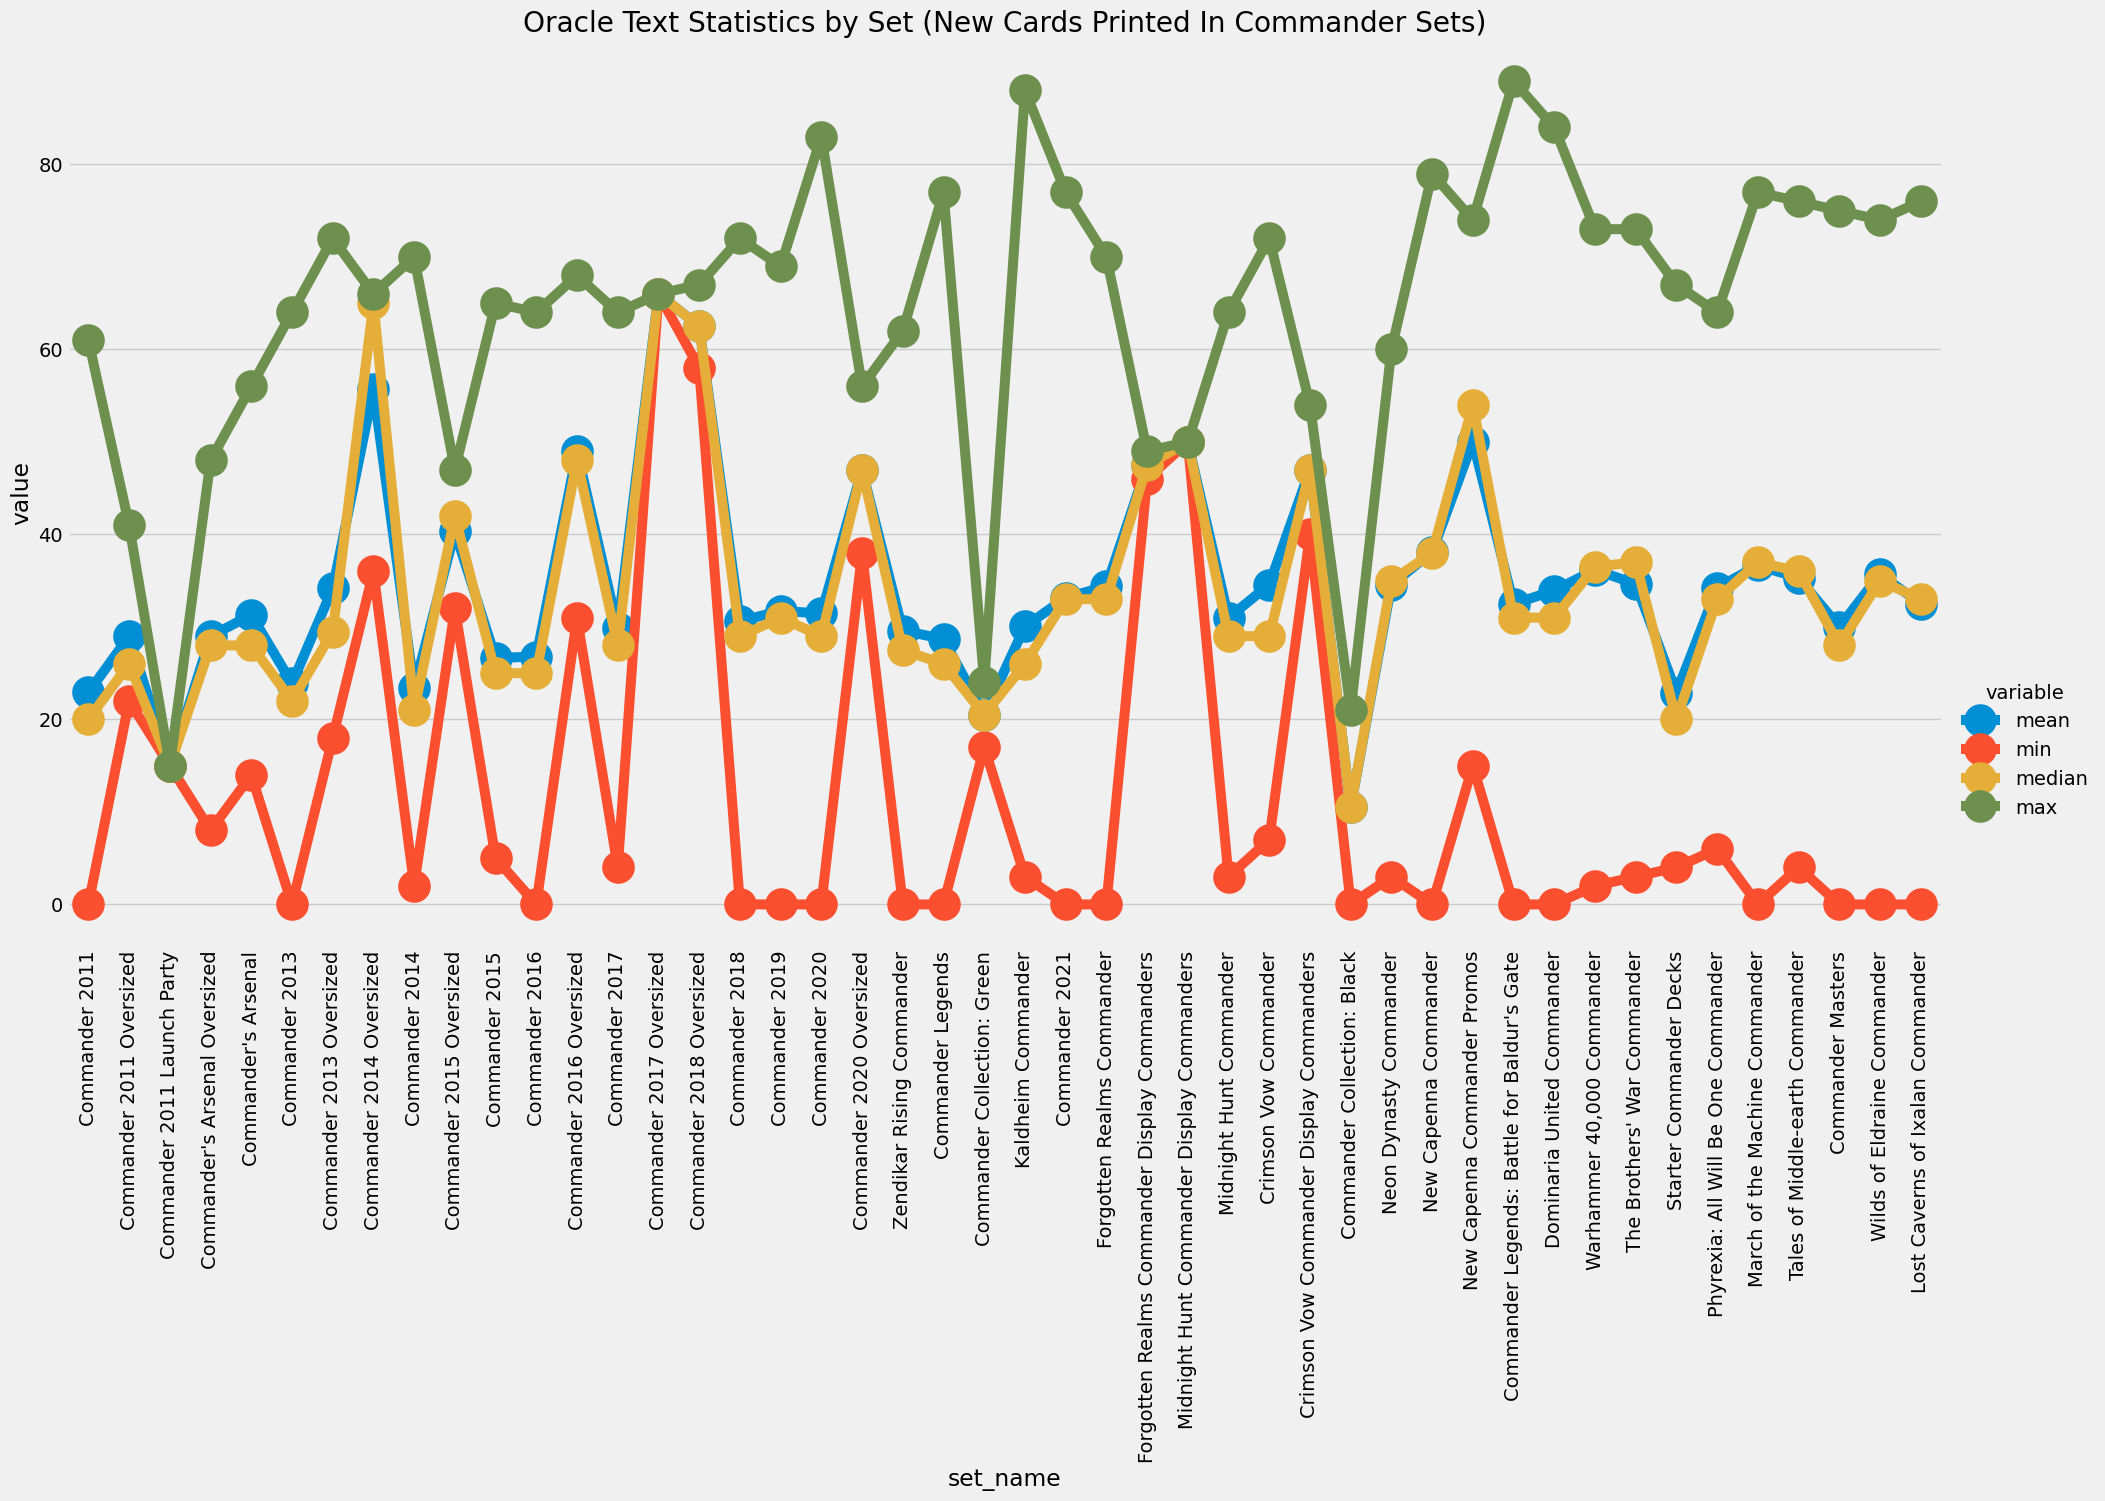

In [110]:
unique_commander_df.loc[:, 'released_at'] = pd.to_datetime(unique_commander_df['released_at'])
unique_commander_df.loc[:, 'year'] = unique_commander_df['released_at'].dt.year

# Group the data by 'year' and get the number of cards in each group
cards_per_year = unique_commander_df.groupby('year').size()

# Create a graph showing the number of cards per year
cards_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of New Commander Cards per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')
plt.show()

# Count the number of words in each oracle_text
unique_commander_df = unique_commander_df.copy()
unique_commander_df['word_count'] = unique_commander_df['oracle_text'].apply(lambda x: len(str(x).split()))

# Group by set and year, and calculate mean, median, min, and max word count
stats = unique_commander_df.groupby(['set_name', 'year'])['word_count'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Reshape the DataFrame for easier plotting
melted_stats = stats.melt(id_vars=['set_name', 'year'], value_vars=['mean', 'median', 'min', 'max'])

# Create a bar plot with 'year' on the x-axis
sns.catplot(data=melted_stats, x='year', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.title('Oracle Text Statistics by Set (New Cards Printed In Commander Sets)')
plt.show()

# Merge 'released_at' back into the 'melted_stats' DataFrame
melted_stats = pd.merge(melted_stats, unique_commander_df[['set_name', 'year', 'released_at']].drop_duplicates(), on=['set_name', 'year'], how='left')

# Sort the DataFrame by 'released_at'
melted_stats_sorted = melted_stats.sort_values(by='released_at')

# Create a bar plot with 'set_name' on the x-axis
sns.catplot(data=melted_stats_sorted, x='set_name', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Oracle Text Statistics by Set (New Cards Printed In Commander Sets)')
plt.show()